# DRL 모델 테스트 노트북

이 노트북에서는 훈련된 DRL 모델을 로드하고 임의의 입력에 대한 출력을 테스트합니다.

## Step 1: 필요한 라이브러리 Import

In [26]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path

# 프로젝트 모듈들 import
import sys
sys.path.append('.')
from drl_framework.network import DQN
from drl_framework.configs import PPDU_DURATION_VARIANTS

print("라이브러리 import 완료!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

라이브러리 import 완료!
PyTorch version: 2.2.0
CUDA available: False


## Step 2: 사용 가능한 모델들 확인

In [27]:
# 사용 가능한 모델 파일들 찾기
model_dir = Path('./obss_comparison_results')
model_files = list(model_dir.glob('*/model.pth'))

print("🔍 사용 가능한 모델들:")
for i, model_file in enumerate(model_files):
    print(f"{i+1:2d}. {model_file.parent.name}")
    
print(f"\n총 {len(model_files)}개 모델 발견")

🔍 사용 가능한 모델들:
 1. trained_model_obss_100
 2. ppdu_long_obss_200
 3. ppdu_extra_long_obss_50
 4. ppdu_short_obss_50
 5. ppdu_long_obss_100
 6. trained_model_obss_50
 7. ppdu_medium_obss_200
 8. ppdu_random_obss_100
 9. ppdu_extra_long_obss_200
10. ppdu_short_obss_200
11. random_env_robust_model
12. ppdu_medium_obss_100
13. ppdu_medium_obss_50
14. ppdu_short_obss_100
15. ppdu_extra_long_obss_100
16. ppdu_long_obss_50

총 16개 모델 발견


## Step 3: 특정 모델 선택 및 로드

In [28]:
# 모델 선택 (인덱스 변경하여 다른 모델 테스트 가능)
model_idx = 7  # 첫 번째 모델 선택
selected_model = model_files[model_idx]

print(f"선택된 모델: {selected_model.parent.name}")
print(f"모델 경로: {selected_model}")

# 모델 로드
device = torch.device('cpu')  # CPU 사용
checkpoint = torch.load(selected_model, map_location=device, weights_only=False)

print("\n📦 체크포인트 내용:")
for key in checkpoint.keys():
    print(f"  - {key}")

# 모델 정보 출력
if 'obss_duration' in checkpoint:
    print(f"\n🏷️  모델 정보:")
    print(f"  OBSS Duration: {checkpoint['obss_duration']} slots")
    
if 'ppdu_variant' in checkpoint:
    ppdu_variant = checkpoint['ppdu_variant']
    ppdu_duration = checkpoint.get('ppdu_duration', 'unknown')
    print(f"  PPDU Variant: {ppdu_variant} ({ppdu_duration} slots)")
    
if 'steps_done' in checkpoint:
    print(f"  Training Steps: {checkpoint['steps_done']}")

선택된 모델: ppdu_random_obss_100
모델 경로: obss_comparison_results/ppdu_random_obss_100/model.pth

📦 체크포인트 내용:
  - policy_net_state_dict
  - target_net_state_dict
  - optimizer_state_dict
  - episode_rewards
  - episode_losses
  - steps_done
  - obss_duration
  - ppdu_variant
  - ppdu_duration
  - random_env

🏷️  모델 정보:
  OBSS Duration: 100 slots
  PPDU Variant: medium (33 slots)
  Training Steps: 4885


## Step 4: DQN 모델 초기화 및 가중치 로드

In [29]:
# DQN 모델 초기화
model = DQN(n_observations=4, n_actions=2).to(device)

# 학습된 가중치 로드
model.load_state_dict(checkpoint['policy_net_state_dict'])
model.eval()  # 평가 모드로 설정

print("✅ DQN 모델 로드 완료!")
print(f"모델 구조:")
print(model)

# 모델 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n📊 모델 파라미터:")
print(f"  총 파라미터: {total_params:,}")
print(f"  훈련 가능한 파라미터: {trainable_params:,}")

✅ DQN 모델 로드 완료!
모델 구조:
DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=64, bias=True)
  (layer3): Linear(in_features=64, out_features=2, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

📊 모델 파라미터:
  총 파라미터: 9,026
  훈련 가능한 파라미터: 9,026


## Step 5: 입력 형식 이해하기

DRL 모델의 입력은 4차원 벡터입니다:
1. **primary_channel_obss_occupied_remained**: Primary 채널의 OBSS 잔여 시간 (슬롯 수)
2. **radio_transition_time**: 라디오 전환 시간 (보통 1 슬롯)
3. **tx_duration**: 전송 지속 시간 (PPDU duration)
4. **cw_index**: Contention Window 인덱스 (0-7, 백오프 단계)

In [30]:
# 예제 입력 데이터 생성 함수
def create_test_inputs():
    """다양한 테스트 시나리오를 위한 입력 생성"""
    test_cases = [
        {
            'name': 'Short OBSS, Low CW',
            'input': [10, 1, 33, 0],  # OBSS 10 slots 남음, 낮은 충돌
            'description': 'OBSS가 곧 끝나고 충돌이 적은 상황'
        },
        {
            'name': 'Long OBSS, Low CW', 
            'input': [150, 1, 33, 0],  # OBSS 150 slots 남음, 낮은 충돌
            'description': 'OBSS가 길게 남고 충돌이 적은 상황'
        },
        {
            'name': 'Long OBSS, High CW',
            'input': [150, 1, 33, 5],  # OBSS 150 slots 남음, 높은 충돌
            'description': 'OBSS가 길게 남고 충돌이 많은 상황'
        },
        {
            'name': 'Short OBSS, High CW',
            'input': [5, 1, 33, 6],   # OBSS 5 slots 남음, 매우 높은 충돌
            'description': 'OBSS가 거의 끝나지만 충돌이 매우 많은 상황'
        },
        {
            'name': 'Medium OBSS, Medium CW',
            'input': [50, 1, 33, 3],  # OBSS 50 slots 남음, 중간 충돌
            'description': '보통 상황'
        }
    ]
    return test_cases

test_cases = create_test_inputs()
print("🧪 테스트 케이스 준비 완료!")
for i, case in enumerate(test_cases):
    print(f"{i+1}. {case['name']}: {case['input']}")
    print(f"   → {case['description']}")

🧪 테스트 케이스 준비 완료!
1. Short OBSS, Low CW: [10, 1, 33, 0]
   → OBSS가 곧 끝나고 충돌이 적은 상황
2. Long OBSS, Low CW: [150, 1, 33, 0]
   → OBSS가 길게 남고 충돌이 적은 상황
3. Long OBSS, High CW: [150, 1, 33, 5]
   → OBSS가 길게 남고 충돌이 많은 상황
4. Short OBSS, High CW: [5, 1, 33, 6]
   → OBSS가 거의 끝나지만 충돌이 매우 많은 상황
5. Medium OBSS, Medium CW: [50, 1, 33, 3]
   → 보통 상황


## Step 6: 모델 예측 함수 정의

In [31]:
def predict_action(model, input_vector, verbose=True):
    """
    주어진 입력에 대해 모델의 예측을 수행
    
    Args:
        model: 로드된 DQN 모델
        input_vector: [obss_remain, radio_time, ppdu_duration, cw_index]
        verbose: 상세 출력 여부
    
    Returns:
        dict: 예측 결과
    """
    # 입력을 텐서로 변환
    input_tensor = torch.tensor(input_vector, dtype=torch.float32, device=device).unsqueeze(0)
    
    with torch.no_grad():
        # Q-values 예측
        q_values = model(input_tensor)
        
        # 최고 Q-value를 가진 액션 선택
        predicted_action = q_values.argmax(dim=1).item()
        
        # 결과 정리
        result = {
            'input': input_vector,
            'q_values': q_values.squeeze().tolist(),
            'predicted_action': predicted_action,
            'action_name': 'Stay Primary' if predicted_action == 0 else 'Switch to NPCA',
            'confidence': torch.softmax(q_values, dim=1).squeeze().tolist()
        }
    
    if verbose:
        print(f"📊 입력: {input_vector}")
        print(f"   Q-values: Stay={result['q_values'][0]:.3f}, Switch={result['q_values'][1]:.3f}")
        print(f"   예측 액션: {result['predicted_action']} ({result['action_name']})")
        print(f"   신뢰도: Stay={result['confidence'][0]:.3f}, Switch={result['confidence'][1]:.3f}")
        print()
    
    return result

print("🔮 예측 함수 준비 완료!")

🔮 예측 함수 준비 완료!


## Step 7: 테스트 케이스들에 대해 예측 실행

In [33]:
print("🚀 모든 테스트 케이스에 대해 예측 실행...\n")

results = []
for i, case in enumerate(test_cases):
    print(f"\n{'='*60}")
    print(f"테스트 케이스 {i+1}: {case['name']}")
    print(f"상황: {case['description']}")
    print(f"{'='*60}")
    
    result = predict_action(model, case['input'], verbose=True)
    result['case_name'] = case['name']
    result['description'] = case['description']
    results.append(result)

print("\n✅ 모든 테스트 케이스 완료!")

🚀 모든 테스트 케이스에 대해 예측 실행...


테스트 케이스 1: Short OBSS, Low CW
상황: OBSS가 곧 끝나고 충돌이 적은 상황
📊 입력: [10, 1, 33, 0]
   Q-values: Stay=26.357, Switch=18.298
   예측 액션: 0 (Stay Primary)
   신뢰도: Stay=1.000, Switch=0.000


테스트 케이스 2: Long OBSS, Low CW
상황: OBSS가 길게 남고 충돌이 적은 상황
📊 입력: [150, 1, 33, 0]
   Q-values: Stay=51.389, Switch=21.667
   예측 액션: 0 (Stay Primary)
   신뢰도: Stay=1.000, Switch=0.000


테스트 케이스 3: Long OBSS, High CW
상황: OBSS가 길게 남고 충돌이 많은 상황
📊 입력: [150, 1, 33, 5]
   Q-values: Stay=50.110, Switch=20.872
   예측 액션: 0 (Stay Primary)
   신뢰도: Stay=1.000, Switch=0.000


테스트 케이스 4: Short OBSS, High CW
상황: OBSS가 거의 끝나지만 충돌이 매우 많은 상황
📊 입력: [5, 1, 33, 6]
   Q-values: Stay=23.682, Switch=16.641
   예측 액션: 0 (Stay Primary)
   신뢰도: Stay=0.999, Switch=0.001


테스트 케이스 5: Medium OBSS, Medium CW
상황: 보통 상황
📊 입력: [50, 1, 33, 3]
   Q-values: Stay=32.485, Switch=20.577
   예측 액션: 0 (Stay Primary)
   신뢰도: Stay=1.000, Switch=0.000


✅ 모든 테스트 케이스 완료!


## Step 8: 결과 분석 및 시각화

In [34]:
# 결과를 DataFrame으로 정리
import pandas as pd

df_data = []
for result in results:
    df_data.append({
        'Case': result['case_name'],
        'OBSS_Remain': result['input'][0],
        'Radio_Time': result['input'][1], 
        'PPDU_Duration': result['input'][2],
        'CW_Index': result['input'][3],
        'Q_Stay': result['q_values'][0],
        'Q_Switch': result['q_values'][1],
        'Predicted_Action': result['predicted_action'],
        'Action_Name': result['action_name'],
        'Conf_Stay': result['confidence'][0],
        'Conf_Switch': result['confidence'][1]
    })

df = pd.DataFrame(df_data)
print("📋 결과 요약:")
print(df[['Case', 'OBSS_Remain', 'CW_Index', 'Action_Name', 'Q_Stay', 'Q_Switch']].round(3))

📋 결과 요약:
                     Case  OBSS_Remain  CW_Index   Action_Name  Q_Stay  \
0      Short OBSS, Low CW           10         0  Stay Primary  26.357   
1       Long OBSS, Low CW          150         0  Stay Primary  51.389   
2      Long OBSS, High CW          150         5  Stay Primary  50.110   
3     Short OBSS, High CW            5         6  Stay Primary  23.682   
4  Medium OBSS, Medium CW           50         3  Stay Primary  32.485   

   Q_Switch  
0    18.298  
1    21.667  
2    20.872  
3    16.641  
4    20.577  


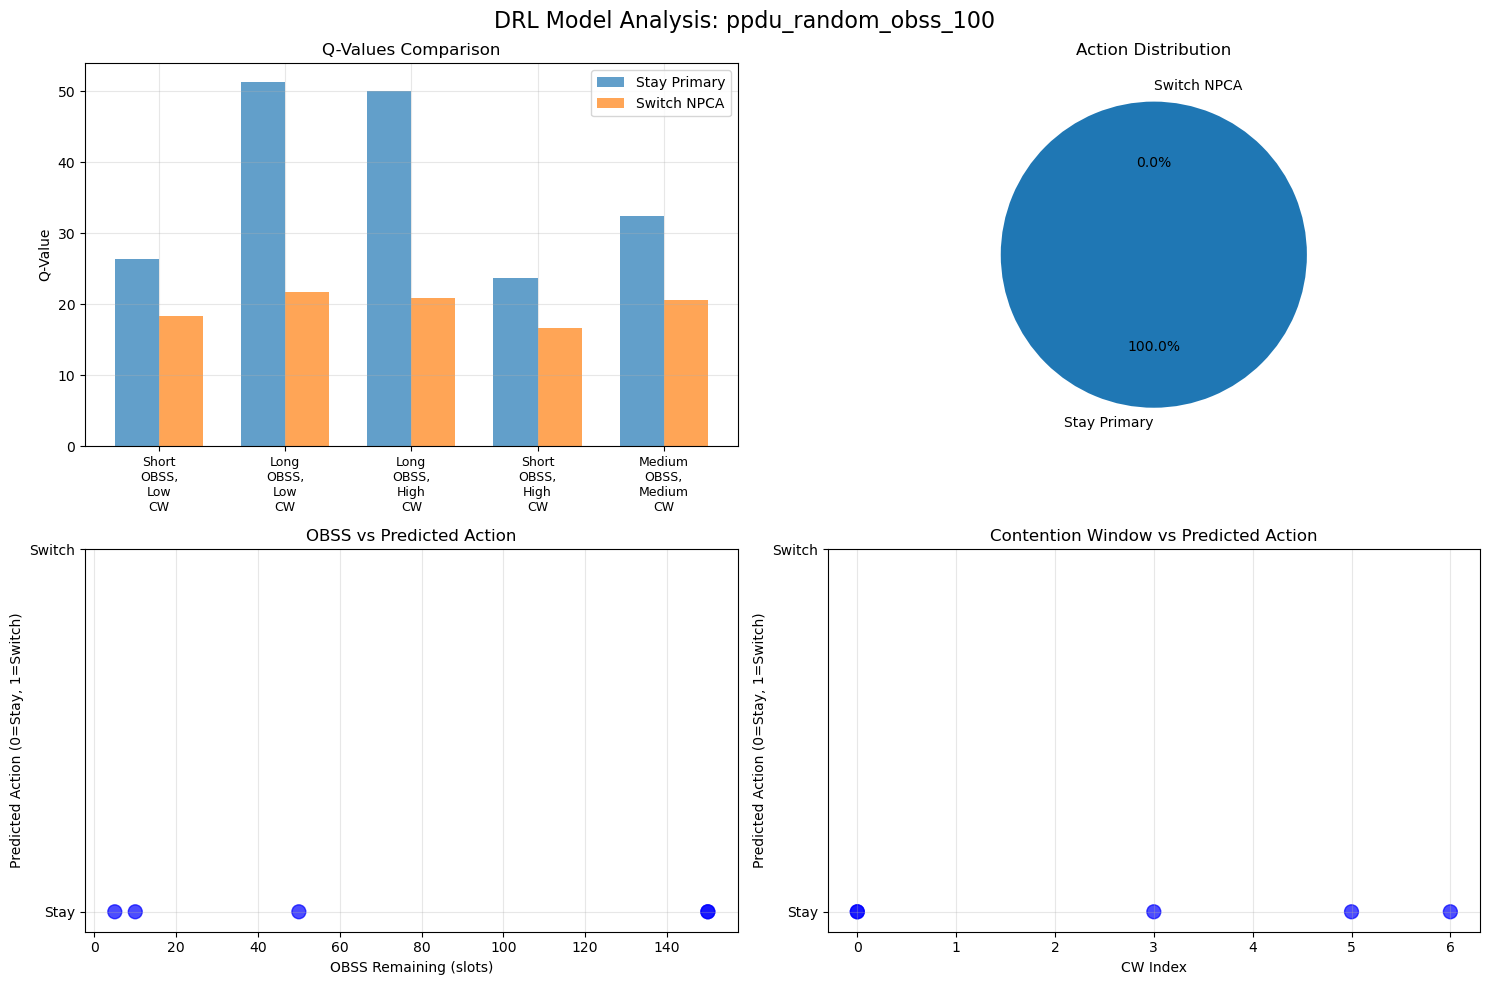

In [35]:
# 결과 시각화
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(f'DRL Model Analysis: {selected_model.parent.name}', fontsize=16)

# 1. Q-values 비교
ax1 = axes[0, 0]
case_names = [r['case_name'] for r in results]
q_stay = [r['q_values'][0] for r in results]
q_switch = [r['q_values'][1] for r in results]

x = range(len(case_names))
width = 0.35

ax1.bar([i - width/2 for i in x], q_stay, width, label='Stay Primary', alpha=0.7)
ax1.bar([i + width/2 for i in x], q_switch, width, label='Switch NPCA', alpha=0.7)
ax1.set_title('Q-Values Comparison')
ax1.set_ylabel('Q-Value')
ax1.set_xticks(x)
ax1.set_xticklabels([name.replace(' ', '\n') for name in case_names], rotation=0, fontsize=9)
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. 액션 분포
ax2 = axes[0, 1]
action_counts = [0, 0]  # [Stay, Switch]
for result in results:
    action_counts[result['predicted_action']] += 1
    
ax2.pie(action_counts, labels=['Stay Primary', 'Switch NPCA'], autopct='%1.1f%%', startangle=90)
ax2.set_title('Action Distribution')

# 3. OBSS vs Action
ax3 = axes[1, 0]
obss_values = [r['input'][0] for r in results]
actions = [r['predicted_action'] for r in results]
colors = ['blue' if a == 0 else 'red' for a in actions]
ax3.scatter(obss_values, actions, c=colors, s=100, alpha=0.7)
ax3.set_xlabel('OBSS Remaining (slots)')
ax3.set_ylabel('Predicted Action (0=Stay, 1=Switch)')
ax3.set_title('OBSS vs Predicted Action')
ax3.set_yticks([0, 1])
ax3.set_yticklabels(['Stay', 'Switch'])
ax3.grid(True, alpha=0.3)

# 4. CW vs Action
ax4 = axes[1, 1]
cw_values = [r['input'][3] for r in results]
ax4.scatter(cw_values, actions, c=colors, s=100, alpha=0.7)
ax4.set_xlabel('CW Index')
ax4.set_ylabel('Predicted Action (0=Stay, 1=Switch)')
ax4.set_title('Contention Window vs Predicted Action')
ax4.set_yticks([0, 1])
ax4.set_yticklabels(['Stay', 'Switch'])
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 9: 임의의 입력으로 직접 테스트

In [13]:
# 이 셀을 자유롭게 수정해서 원하는 입력값을 테스트해보세요!

# 사용자 정의 입력 (여기를 수정하세요)
custom_inputs = [
    [100, 1, 20, 0],
]

print("🎯 사용자 정의 입력 테스트:\n")

for i, custom_input in enumerate(custom_inputs):
    print(f"테스트 {i+1}:")
    print("input_vector: [obss_remain, radio_time, ppdu_duration, cw_index]")
    result = predict_action(model, custom_input, verbose=True)
    
    # 간단한 해석
    obss_remain, _, ppdu_dur, cw_idx = custom_input
    
    # print(f"💡 해석: ", end="")
    # if obss_remain > 100:
    #     print(f"OBSS가 매우 길어서({obss_remain} slots) ", end="")
    # elif obss_remain > 50:
    #     print(f"OBSS가 길어서({obss_remain} slots) ", end="")
    # else:
    #     print(f"OBSS가 짧아서({obss_remain} slots) ", end="")
        
    # if result['predicted_action'] == 1:
    #     print("즉시 NPCA로 스위치하는 것이 유리")
    # else:
    #     print("Primary에서 기다리는 것이 유리")
        
    print("-" * 50)

🎯 사용자 정의 입력 테스트:

테스트 1:
input_vector: [obss_remain, radio_time, ppdu_duration, cw_index]
📊 입력: [100, 1, 20, 0]
   Q-values: Stay=21.497, Switch=11.610
   예측 액션: 0 (Stay Primary)
   신뢰도: Stay=1.000, Switch=0.000

--------------------------------------------------


## Step 10: 모델 학습 곡선 확인 (보너스)

📈 학습 통계:
  총 에피소드: 5000
  최대 보상: 2.31
  최종 평균 보상 (마지막 50 에피소드): 1.14


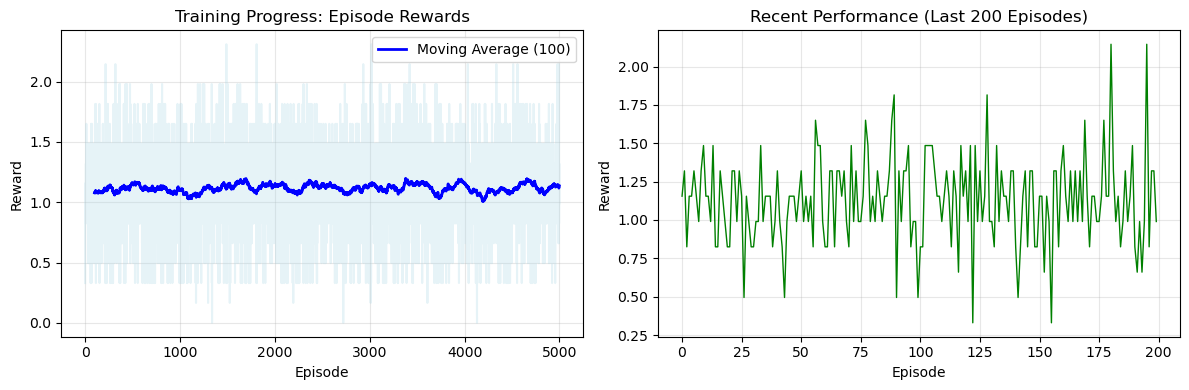

In [12]:
# 학습 곡선이 저장되어 있다면 시각화
if 'episode_rewards' in checkpoint:
    episode_rewards = checkpoint['episode_rewards']
    
    plt.figure(figsize=(12, 4))
    
    # 원본 보상
    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards, alpha=0.3, color='lightblue')
    
    # 이동평균 (100 에피소드)
    window_size = min(100, len(episode_rewards) // 10)
    if len(episode_rewards) >= window_size:
        moving_avg = np.convolve(episode_rewards, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(episode_rewards)), moving_avg, 'b-', linewidth=2, label=f'Moving Average ({window_size})')
    
    plt.title('Training Progress: Episode Rewards')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 최근 성능
    plt.subplot(1, 2, 2)
    recent_rewards = episode_rewards[-200:] if len(episode_rewards) > 200 else episode_rewards
    plt.plot(recent_rewards, 'g-', linewidth=1)
    plt.title('Recent Performance (Last 200 Episodes)')
    plt.xlabel('Episode')
    plt.ylabel('Reward')
    plt.grid(True, alpha=0.3)
    
    # 통계 출력
    print(f"📈 학습 통계:")
    print(f"  총 에피소드: {len(episode_rewards)}")
    print(f"  최대 보상: {max(episode_rewards):.2f}")
    print(f"  최종 평균 보상 (마지막 50 에피소드): {np.mean(episode_rewards[-50:]):.2f}")
    
    plt.tight_layout()
    plt.show()
else:
    print("학습 곡선 데이터가 없습니다.")

## 🎉 완료!

이제 다음을 할 수 있습니다:
1. **다른 모델 테스트**: `model_idx` 값을 변경하여 다른 훈련된 모델 로드
2. **커스텀 입력**: Step 9에서 원하는 입력값 [obss_remain, radio_time, ppdu_duration, cw_index] 테스트
3. **결과 해석**: 모델이 왜 특정 액션을 선택했는지 Q-values를 통해 분석

### 입력 형식 참고:
- **obss_remain**: 0-500 (OBSS 잔여 시간, 슬롯 수)
- **radio_time**: 1 (고정값)
- **ppdu_duration**: 20/33/50/80 (프레임 크기에 따라)
- **cw_index**: 0-7 (충돌 정도, 0=낮음, 7=높음)

### 출력 해석:
- **Action 0**: Stay Primary (기다림)
- **Action 1**: Switch to NPCA (즉시 스위치)